# Linear probabilistic generating functions

Perception in a passive agent using linear probabilistic generating functions.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from scipy.stats import norm
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

## Example 2.1: Linear, probabilistic generative model

In this example and beyond we will omit references to the specific steps of our modeling framework and just define the pieces we need. First we define the generative process:

$$
    \mathscr{E} \triangleq 
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* x^* & \text{Generating function} \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

In this example the generated sensory data is "corrupted" or made probabilistic due to Gaussian noise. Let's set up the generative process in code form so that we can visualize it. In setting up the generative process we assume that points are generated according to the generating function with added Gaussian noise.

In [2]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def _noise(self):
        return np.random.normal(loc=0, scale=self.params.y_star_std)
    
    def generating_function(self, x_star: float) -> float:
        return self.params.beta_1_star * x_star + self.params.beta_0_star
    
    def generate(self, x_star: float) -> float:
        return self.generating_function(x_star) + self._noise()
    
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 0.5   # Standard deviation of sensory data
}

# Initialize the environment and support of x
env       = StaticEnvironment(env_params)
x_range   = np.linspace(start=0.01, stop=5, num=500)

# Generate data
y = np.zeros(x_range.shape[0])

for idx, x in enumerate(x_range):
    y[idx] = env.generate(x)

<Figure size 432x288 with 0 Axes>

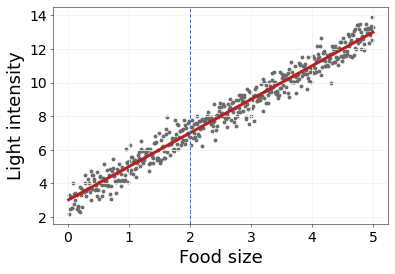

In [3]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range, env.generating_function(x_range),
        c="#B22222", linewidth=3)

# Noisy samples
ax.scatter(x_range,y,
        c="#696969", s=8)

ax.axvline(x=2, linestyle="dashed", linewidth=1)

# Axis labels and styling
ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Next we will specify the following generative model:

$$
    \mathcal{M} \triangleq 
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; g_{\mathcal{M}}, \sigma^2_y) & \text{Likelihood} \\
        p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; m_x, s^2_x) & \text{Prior on } x \\
        g_{\mathcal{M}}(x, \theta) = \beta_0 + \beta_1 x & \text{Generating function} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Linear parameters} \\ 
        \phi := \left \{\sigma^2_y = 0.25, s^2_x = 0.25, m_x = 4 \right \} & \text{Other parameters}
    \end{cases}
$$

Now we have a proper distribution for the likelihood and prior. Both are normal distributions without any of the degenerate properties introduced in the previous example. Once again, we have assumed that the parameters are given under the assumption that they have been learned already.

The previous example used a uniform prior. Here we use a Gaussian prior. We can interpret the prior as the agent's previous experience with this state. From prior knowledge, before seeing new data, it has a sense of what the mean is typically centered around. The prior can influence our hidden state estimate as we will see clearly in a moment. In this case, because we will only use one sample of $y$ the prior will have a particularly strong effect on our posterior "belief" (probability) of the hidden state that generated the observation. 

With this in mind, we can define our static agent. The only change between this example and the previous is the addition of the Gaussian prior (instead of uniform) in which $m_x=4$ and $s_x = 0.5$.

In [4]:
class StaticAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        self.likelihood = None
        self.prior = None
        
    def gm(self):
        return self.params.beta_1 * self.params.x_range + self.params.beta_0
        
    def generative_model(self, y: float):
        self.likelihood = norm.pdf(y, loc=self.gm(), scale=self.params.std_y)
        self.prior      = norm.pdf(x_range, loc=self.params.mu_x, scale=self.params.std_x)
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        gen_model = self.generative_model(y)
        evidence  = np.sum(gen_model, axis=0)
        posterior = gen_model / evidence
        return posterior

Now assuming that $x^*=2$, we can generate a deterministic observation at $y=7$ and perform Bayesian inference.

In [5]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 0.5  # Standard deviation of sensory data
}

# Agent parameters
agent_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
    "std_y"  : 0.5,  # Likelihood standard deviation
    "mu_x"   : 4,    # Prior mean
    "std_x"  : 0.5,  # Prior standard deviation
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

In [6]:
# Initialize environment and agent
env       = StaticEnvironment(env_params)
agent     = StaticAgent(agent_params)

# Set true state and generate sensory data
x_star    = 2
y         = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
posterior = agent.infer_state(y)

<Figure size 432x288 with 0 Axes>

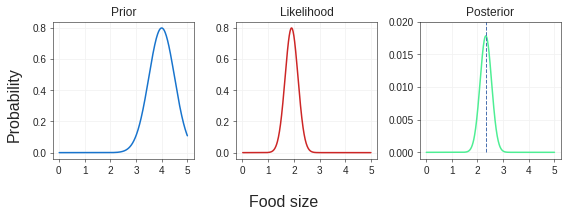

In [7]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].vlines(x=(np.argmax(posterior) + 1) / 100, ymin=0, ymax=0.020, linestyles="dashed", linewidth=1)
axes[2].set_ylim([-0.001, 0.02])

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [8]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7 under prior assumptions.')

The posterior mode is 2.33. This is the most likely (expected) food size, the highest probability hidden state estimate, when the observed light intensity is 7 under prior assumptions.


Using the inverse equation for the generating function we can calculate what the true state should be. We expect $x=2$. However, according to the posterior mode estimate above, the posterior is right-shifted to $2.4$. We can say that agent's belief about the hidden state is that it is $2.4$ but the true state is $2$. This illustrates the effect of the prior on our prediction. Past experience can dictate the future belief. Since the posterior is a a kind of average between the prior and likelihood, the prior's right-shifted mean ends up producing a posterior mean between the means of the likelihood (2) and prior (4).